In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1, index_col='ID')
df.rename({'default payment next month': 'default'}, axis=1, inplace=True)

In [3]:
# df[:9].T.head(24)

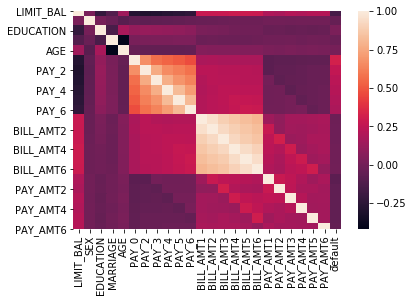

In [4]:
sns.heatmap(df.corr())

In [5]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [6]:
df.shape

(30000, 24)

In [7]:
# Combine other small categories  
df.loc[(df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0), 'EDUCATION'] = 4

In [8]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [9]:
# Combine to have 1:married, 2:single, 3:other
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

In [10]:
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [11]:
df.rename({'PAY_0': 'pay_stat_sep', 'PAY_2': 'pay_stat_aug', 'PAY_3': 'pay_stat_jul', 'PAY_4': 'pay_stat_jun', 'PAY_5': 
           'pay_stat_may', 'PAY_6': 'pay_stat_apr'}, axis=1, inplace=True)

In [12]:
for col in df.columns:
    df.rename({'{}'.format(col): '{}'.format(col.lower())}, axis=1, inplace=True)

In [13]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
for i, c in enumerate(months):
    df[f'deferred_payment_{c}'] = np.where(df[f'pay_stat_{c}']<=0, 0, 1)

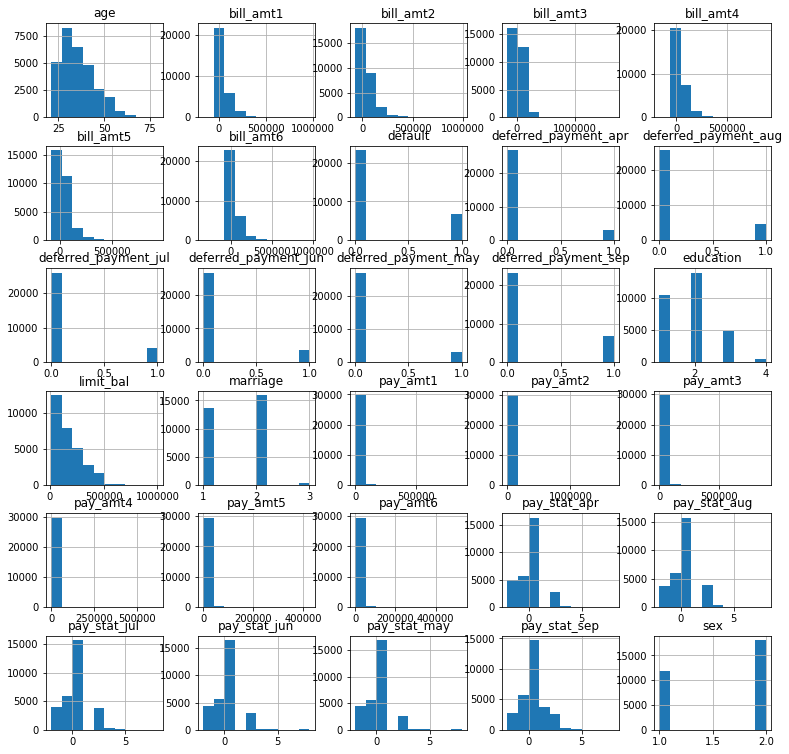

In [14]:
ax = df.hist(figsize=(13,13))

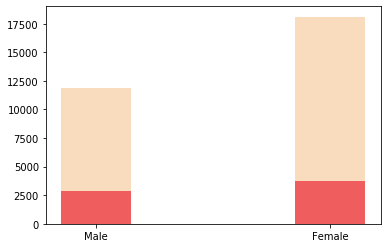

In [15]:
p1 = plt.bar(['Male', 'Female'],[df.default.loc[df['sex'] == 1].value_counts()[1], df.default.loc[df['sex'] == 2].value_counts()[1]], color='#f05d5e', width=0.3)
p2 = plt.bar(['Male', 'Female'],[df.default.loc[df['sex'] == 1].value_counts()[0], df.default.loc[df['sex'] == 2].value_counts()[0]], color='#f9dbbd', 
             bottom=[df.default.loc[df['sex'] == 1].value_counts()[1], df.default.loc[df['sex'] == 2].value_counts()[1]], width=.3)
plt.show()

In [16]:
# [df.default.loc[df['sex'] == 1].value_counts()[0], 
#                             df.default.loc[df['sex'] == 2].value_counts()[0],
#                             df.default.loc[df['sex'] == 1].value_counts()[1],
#                             df.default.loc[df['sex'] == 2].value_counts()[1]]

In [17]:
# sns.barplot(x='default', y=[9015, 14349, 2873, 3763], hue='sex', data=df)

In [18]:
X = df.drop('default', axis=1)
y = df['default']

In [19]:
# Boxcox needs +ve non-zero data so we abs and add 1 
# (this messes with and negative amounts owed but PCA ends up not working anyway so it doesn't matter)
# Maybe adding the minimum value in the whole df to each value would be a work around

df_pca = np.abs(df) +1
df_TF = pd.DataFrame(index=df.index)
for i in df_pca.columns.values:
    df_TF["%s_TF" % i] = boxcox(df_pca.loc[:, i])[0]

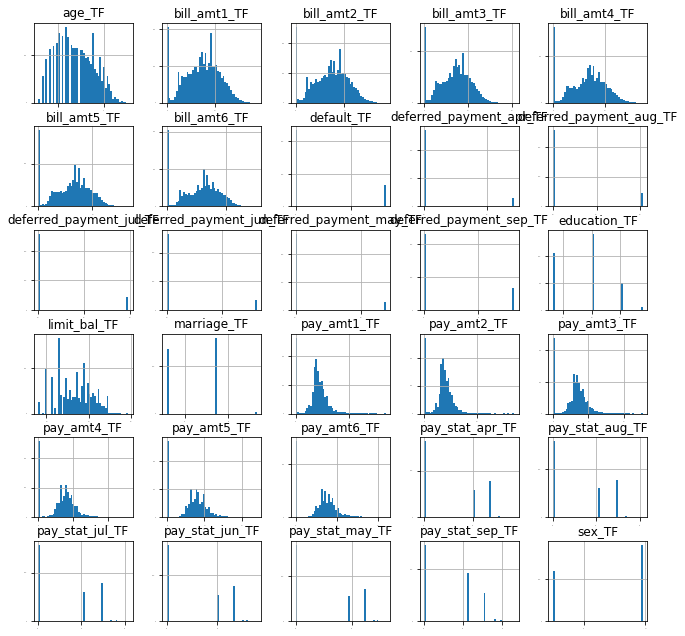

In [20]:
ax = df_TF.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

In [21]:
# Scaled to have 0 mean and sd of 1

df_TF = StandardScaler().fit_transform(df_TF)

print("mean: ", np.round(df_TF.mean(), 2))
print("standard dev: ", np.round(df_TF.std(), 2))

mean:  0.0
standard dev:  1.0


In [22]:
fit = PCA()
pca = fit.fit_transform(df_TF)

Text(0, 0.5, 'Variance Explained')

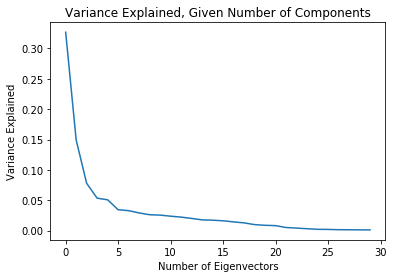

In [23]:
plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")

Text(0, 0.5, 'Total Variance Explained')

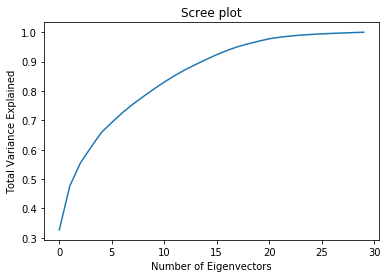

In [24]:
# We see that to get a space able to explain the majority of the data we'd need almost as many axes as the base data has.
# We therefore stop using PCA

plt.plot(np.cumsum(fit.explained_variance_ratio_))
plt.title("Scree plot")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Total Variance Explained")

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 137)

In [27]:
scaler = MinMaxScaler()  

X_train_sc = scaler.fit_transform(X_train)  
X_test_sc = scaler.transform(X_test)  

In [28]:
knn1 = KNeighborsClassifier(n_neighbors=1)

In [29]:
knn1.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [30]:
pred1 = knn1.predict(X_test_sc)
prob1 = knn1.predict_proba(X_test_sc)

In [33]:
roc_auc_score(y_test, prob1[:,1])

0.6074757446425915

In [34]:
knn_grid = KNeighborsClassifier(n_jobs=-1)

In [35]:

param_grid_knn = {'n_neighbors':range(6, 10),'weights':['uniform', 'distance'], 'p':range(1,10+1)}

opt_model_knn = GridSearchCV(knn_grid, param_grid_knn, cv=10, scoring='roc_auc')
opt_model_knn.fit(X_train_sc, y_train)
best_model_knn = opt_model_knn.best_estimator_

opt_model_knn.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

In [36]:
pred_knn = best_model_knn.predict(X_test_sc)
prob_knn = best_model_knn.predict_proba(X_test_sc)

In [37]:
roc_auc_score(y_test, prob_knn[:,1]), roc_auc_score(y_test, pred_knn)

(0.7389756788082048, 0.6480847864413951)

0.7389756788082048

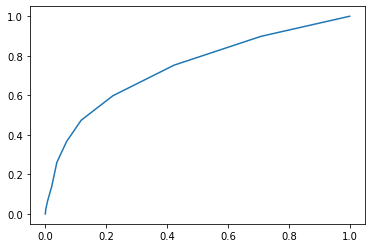

In [38]:
fpr,tpr,thr = roc_curve(y_test, prob_knn[:,1])
sns.lineplot(fpr,tpr)
auc(fpr,tpr)

In [39]:
pd.DataFrame(opt_model_knn.cv_results_).sort_values(by=['rank_test_score'])

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
60       0.114258      0.034344         0.337666        0.011410   
61       0.113759      0.036887         0.346970        0.023493   
40       0.112502      0.031452         0.325951        0.023003   
62       0.110291      0.033720         0.299750        0.021254   
64       0.120868      0.038101         1.566981        0.178827   
..            ...           ...              ...             ...   
15       0.109035      0.032240         1.373611        0.115691   
19       0.122965      0.037402         1.384452        0.124956   
5        0.112160      0.034896         1.447011        0.169409   
7        0.111498      0.032645         1.397287        0.114174   
9        0.110889      0.034524         1.378377        0.128703   

   param_n_neighbors param_p param_weights  \
60                 9       1       uniform   
61                 9       1      distance   
40                 8       1       uniform   
62                 9       2       uniform   
64                 9       3       uniform   
..               ...     ...           ...   
15                 6       8      distance   
19                 6      10      distance   
5                  6       3      distance   
7                  6       4      distance   
9                  6       5      distance   

                                               params  split0_test_score  \
60   {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}           0.717492   
61  {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}           0.717708   
40   {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}           0.714279   
62   {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}           0.713017   
64   {'n_neighbors': 9, 'p': 3, 'weights': 'uniform'}           0.712180   
..                                                ...                ...   
15  {'n_neighbors': 6, 'p': 8, 'weights': 'distance'}           0.708430   
19  {'n_neighbors': 6, 'p': 10, 'weights': 'distan...           0.708455   
5   {'n_neighbors': 6, 'p': 3, 'weights': 'distance'}           0.708234   
7   {'n_neighbors': 6, 'p': 4, 'weights': 'distance'}           0.707806   
9   {'n_neighbors': 6, 'p': 5, 'weights': 'distance'}           0.706242   

    split1_test_score  ...  split3_test_score  split4_test_score  \
60           0.699347  ...           0.718207           0.717020   
61           0.692078  ...           0.712494           0.706695   
40           0.696158  ...           0.712570           0.712025   
62           0.697839  ...           0.710824           0.697136   
64           0.697099  ...           0.709748           0.691727   
..                ...  ...                ...                ...   
15           0.680257  ...           0.697972           0.677842   
19           0.681229  ...           0.698619           0.676615   
5            0.680526  ...           0.689056           0.679146   
7            0.682763  ...           0.693010           0.675030   
9            0.678676  ...           0.695250           0.674566   

    split5_test_score  split6_test_score  split7_test_score  \
60           0.747366           0.741955           0.740328   
61           0.742763           0.735284           0.737681   
40           0.742513           0.733027           0.735171   
62           0.747873           0.741448           0.741418   
64           0.751918           0.741047           0.736421   
..                ...                ...                ...   
15           0.725107           0.719244           0.718577   
19           0.726212           0.718425           0.718032   
5            0.725985           0.712482           0.718016   
7            0.724401           0.713909           0.717900   
9            0.725472           0.716920           0.717565   

    split8_test_score  split9_test_score  mean_test_score  std_test_score  \
60           0.695746           0.730326         0.727545        0.021

In [40]:
ran_for_100 = RandomForestClassifier(n_estimators=100)

In [41]:
param_grid_ran_for_100 = {'max_depth':range(5, 12+1),'min_samples_leaf':[5,10,15]}

opt_model_ran_for_100 = GridSearchCV(ran_for_100, param_grid_ran_for_100, cv=10 ,scoring='roc_auc')
opt_model_ran_for_100.fit(X_train, y_train)
best_model_ran_for_100 = opt_model_ran_for_100.best_estimator_

opt_model_ran_for_100.best_params_

{'max_depth': 11, 'min_samples_leaf': 15}

0.7878239172975753

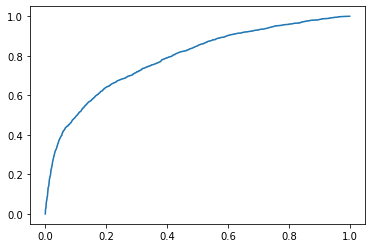

In [42]:
probas= best_model_ran_for_100.predict_proba(X_test)
fpr,tpr,thr = roc_curve(y_test,probas[:,1])
sns.lineplot(fpr,tpr)
auc(fpr,tpr)

In [43]:
best_model_ran_for_100

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

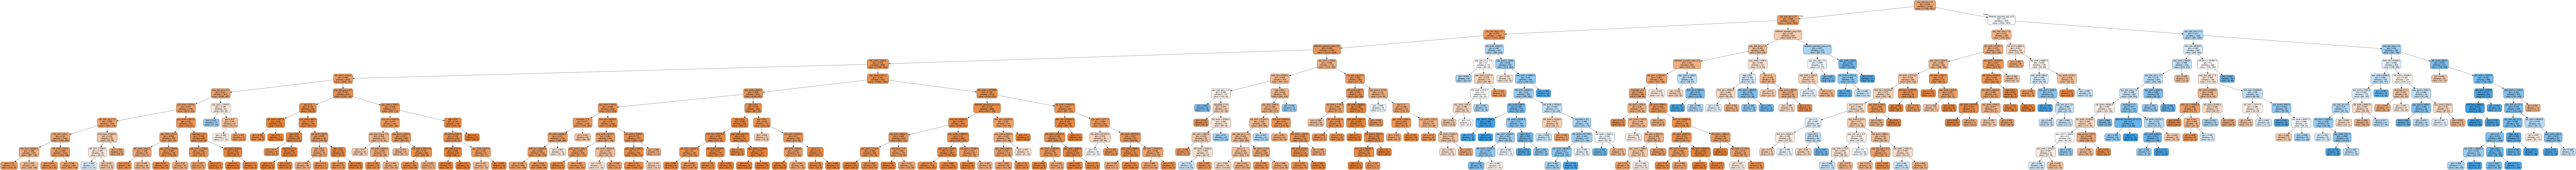

In [44]:
dot_data_tr100 = StringIO()
export_graphviz(best_model_ran_for_100[0], out_file=dot_data_tr100,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data_tr100.getvalue())  
Image(graph.create_png())

In [45]:
list(zip(list(df.columns), list((best_model_ran_for_100).feature_importances_)))

[('limit_bal', 0.03016734188984884),
 ('sex', 0.003997794066668876),
 ('education', 0.004896653790486833),
 ('marriage', 0.004681776676167682),
 ('age', 0.020769212409862244),
 ('pay_stat_sep', 0.19696171942988047),
 ('pay_stat_aug', 0.07261518716485202),
 ('pay_stat_jul', 0.052528871643277054),
 ('pay_stat_jun', 0.017541255726581353),
 ('pay_stat_may', 0.02084381785058752),
 ('pay_stat_apr', 0.013121570334018295),
 ('bill_amt1', 0.03256970819021701),
 ('bill_amt2', 0.027646118761124758),
 ('bill_amt3', 0.022338121851534977),
 ('bill_amt4', 0.022698110878092006),
 ('bill_amt5', 0.02271838631468188),
 ('bill_amt6', 0.021500480200249042),
 ('pay_amt1', 0.02798372074210059),
 ('pay_amt2', 0.025704568877708906),
 ('pay_amt3', 0.023295560591395384),
 ('pay_amt4', 0.022713137042527854),
 ('pay_amt5', 0.0191290011828156),
 ('pay_amt6', 0.021053956158620258),
 ('default', 0.12325260488163418),
 ('deferred_payment_sep', 0.06563157864102569),
 ('deferred_payment_aug', 0.031441035008151465),
 ('d

In [46]:
best_model_ran_for_100.feature_importances_

array([0.03016734, 0.00399779, 0.00489665, 0.00468178, 0.02076921,
       0.19696172, 0.07261519, 0.05252887, 0.01754126, 0.02084382,
       0.01312157, 0.03256971, 0.02764612, 0.02233812, 0.02269811,
       0.02271839, 0.02150048, 0.02798372, 0.02570457, 0.02329556,
       0.02271314, 0.019129  , 0.02105396, 0.1232526 , 0.06563158,
       0.03144104, 0.02577876, 0.01443053, 0.01198942])

In [14]:
# pipe = Pipeline([('scl', MinMaxScaler()),
#                  ('pca', PCA(n_components=10)),
#                  ('svm', SVC())])

In [15]:
# grid = [{'svm__kernel': ['poly', 'sigmoid'],
#          'svm__C': [0.01, 1, 100],
#          'svm__degree0': [2,3,4,5],
#          'svm__gamma': [0.001, 0.01]}]

In [16]:
# gridsearch = GridSearchCV(estimator=pipe,
#                   param_grid=grid,
#                   scoring='accuracy',
#                   cv=3)

In [18]:
# test1 = pipe.fit(X_train, y_train)

In [ ]:
# pred1 = test1.predict(X_test)

In [ ]:
# test1.score(X_test, y_test)

In [ ]:
# roc_auc_score(y_test, pred1)